<a href="https://colab.research.google.com/github/ryoiwata/neural_allstars/blob/main/all_stars/skyler/stringer_dataset_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title UMAP installation
# @markdown the order of these installations matters because Suit2p wants to downgrade numpy and this is not comptabile with the ARIMA package
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 824.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# @title Imports of UMAP, numpy, matplotlib, and data retrieval
from umap import UMAP
import numpy as np
import matplotlib.pyplot as plt
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Load data into memory
dat = np.load(fname, allow_pickle=True).item()
sresp = dat['sresp']
pArea = dat['pupilArea']
beh_mask = dat['beh_svd_mask']
beh_time = dat['beh_svd_time']

print("keys are: ")
for key in dat.keys():
  print('\t',key)
print("response vector shape:", sresp.shape)
print("pupil vector shape:", pArea.shape)
print("beh_svd_mask vector shape:", beh_mask.shape)
print("beh_svd_time vector shape:", beh_time.shape)

keys are: 
	 sresp
	 run
	 beh_svd_time
	 beh_svd_mask
	 stat
	 pupilArea
	 pupilCOM
	 xyz
response vector shape: (11983, 7018)
pupil vector shape: (7018, 1)
beh_svd_mask vector shape: (240, 320, 1000)
beh_svd_time vector shape: (7018, 1000)


In [4]:
# @title helper functions and libraries
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

def plot_activity(spike_data, num, *, win_length:int=500):
  assert type(win_length) != list

  num_subplots = num
  t_bin = 1.2
  if isinstance(win_length,int):
    lower = 0
    upper = win_length
    span = int((upper*t_bin)/60)
  elif isinstance(win_length, tuple):
    lower = win_length[0]
    upper = win_length[1]
    span = (int((lower*t_bin)/60), int((upper*t_bin)/60))
  # else:
  #   raise f"win_length must be of type int or type tuple. Element of type {type(win_length)} was used!"
  subset = zscore(spike_data[:num_subplots], axis=1)
  fig, ax = plt.subplots(nrows=num_subplots, ncols=1, figsize=(8, num_subplots*1.5))
  for idx, activity in enumerate(subset):
    ax[idx].plot(np.arange(lower, upper), activity[lower:upper])
    ax[idx].set(title=f"zscored neuron index {idx}, over {span} mins")
  fig.show()


def plot_activity2(spike_data, num, *, win_length:int=500, sep:int = 5):
  assert type(win_length) != list

  t_bin = 1.2
  ticks = np.arange(0, num*sep , sep)
  if isinstance(win_length,int):
    lower = 0
    upper = win_length
    span = int((upper*t_bin)/60)
  elif isinstance(win_length, tuple):
    lower = win_length[0]
    upper = win_length[1]
    span = (int((lower*t_bin)/60), int((upper*t_bin)/60))
  elif win_length == None:
    lower = 0
    upper = spike_data.shape[1]
  # else:
  #   raise f"win_length must be of type int or type tuple. Element of type {type(win_length)} was used!"
  subset = zscore(spike_data[:num],axis=1)
  subset = subset + ticks[:, np.newaxis]
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 11))
  ax.plot(np.arange(lower, upper), subset[:, lower:upper].T)
  ax.set_yticks(ticks)
  ax.set_yticklabels(np.arange(1,num+1))
  ax.set(title=f"plot of zscore {num} neurons from {(lower*1.2)/60:.2f} to {(upper*1.2)/60:.2f} mins")
  fig.show()


Text(0, 0.5, 'percent of explained variance')

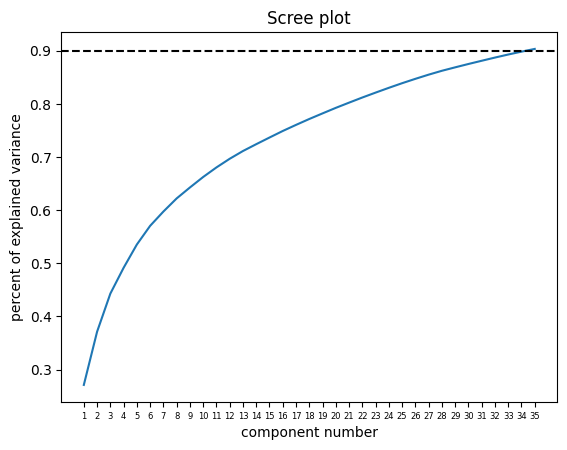

In [5]:
# @title randomly select 100 neurons and perform PCA for top 90% components.
from sklearn.decomposition import PCA
top = 100
np.random.seed(1337)
random_indexes = np.random.choice(range(sresp.shape[0]),size=top, replace=False)
X = sresp[random_indexes,:]
pca = PCA(n_components=.9)
Y = pca.fit(X)
explained = Y.explained_variance_ratio_
fig = plt.figure()
ax = fig.gca()
ax.plot(np.cumsum(explained))
ax.axhline(.9, color='k', linestyle='--')
ax.set_title("Scree plot")
ax.set_xticks(np.arange(0,len(explained)))
ax.set_xticklabels(np.arange(1,len(explained)+1,), fontsize=6)
ax.set_xlabel("component number")
ax.set_ylabel("percent of explained variance")

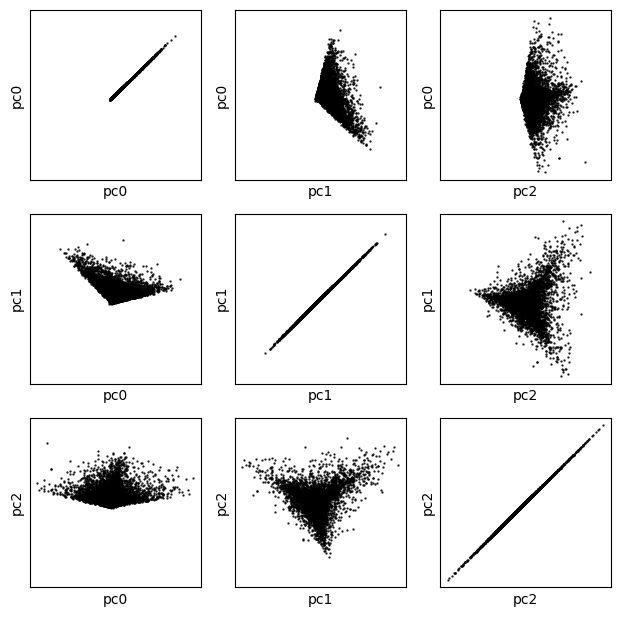

In [6]:
# @title view correlation between first `n` components
rows = cols = 3 #set number of components t view
fig, ax = plt.subplots(nrows=rows, ncols=cols, sharey=True, sharex= True, figsize=(rows*2.5,cols*2.5))
for row in range(rows):
    for col in range(cols):
        ax[row,col].scatter(Y.components_[row,:], Y.components_[col,:], c='k', alpha=.8, s=.5)
        ax[row,col].set_yticks([])
        ax[row,col].set_xticks([])
        ax[row,col].set_ylabel(f"pc{row}")
        ax[row,col].set_xlabel(f"pc{col}")

From paper:
> at a scan rate of 3 or 2.5 Hz. For
three further recordings, we used single-plane
configuration, with a scan rate of 30 Hz.

`help(oasis)`

    oasis(F: numpy.ndarray, batch_size: int, tau: float, fs: float) -> numpy.ndarray
    computes non-negative deconvolution
    
    no sparsity constraints
    
    Parameters
    ----------------
    
    F : float, 2D array
        size [neurons x time], in pipeline uses neuropil-subtracted fluorescence
    
    batch_size : int
        number of frames processed per batch
    
    tau : float
        timescale of the sensor, used for the deconvolution kernel
    
    fs : float
        sampling rate per plane
    
    
    Returns
    ----------------
    
    S : float, 2D array
        size [neurons x time], deconvolved fluorescence

>One important problem is developing methods for spike detection: inferring the times of action potentials from the fluorescence traces. The earliest such methods rely on spike deconvolution algorithms, which infer a spike train **under the assumption that the fluorescence trace represents an approximate convolution of the underlying spike train with the cell's calcium response**

-- Pachitariu 2018

Additional preprocessing that may be done
> results, we excluded neurons whose signal might span two planes by excluding neurons
  in sequential planes that had a greater than a 0.6 correlation (in 1.2-s bins)
  with each other, and whose centers were within 5 mm of each other in XY.


In [7]:
# @title DL Suit2p from Github; apply deconvolution; WARNING!! downgrades numpy
!pip install git+https://github.com/MouseLand/suite2p.git --quiet
from suite2p.extraction.dcnv import oasis

bs = 500
tau = 2.0 #timescale of sensor from paper, page 7.
fs = 30 #hz
smoothed = oasis(X, bs, tau, fs)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.7/171.7 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.4 which is incompatible.
Could not load the sbx reader, installing with

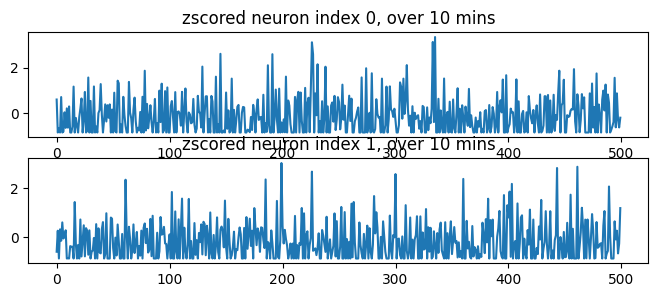

In [8]:
# @title Before
num_neurons = 2 #@param {type:"raw"}

plot_activity(X, num_neurons)

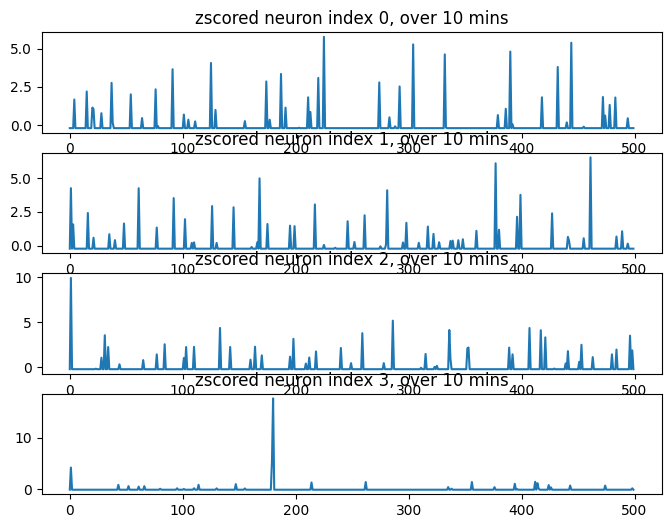

In [9]:
# @title After
num_neurons = 2 #@param {type:"raw"}

plot_activity(smoothed, num_neurons)

# Does neural activity predict pupil size?

Let's compute simple statistics to see if there is a relationship between aggregate neuron activity and pupil are



<ipython-input-10-46219752a933>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  res = np.linalg.lstsq(sum_stat, pArea)


Text(0.02, 0.5, 'pupil area units^2')

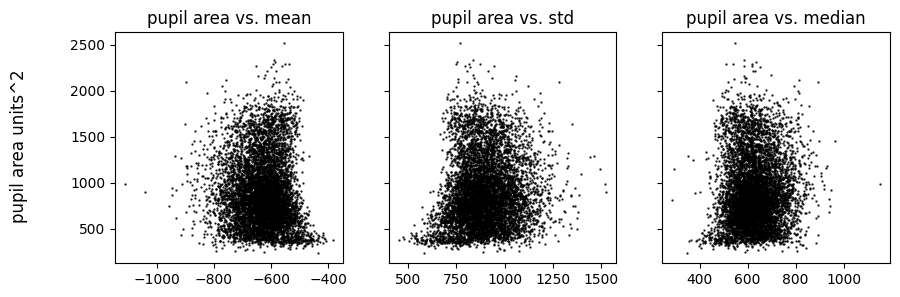

In [10]:
# do we have a statistic for each neuron?
sum_stat = np.column_stack([sresp.mean(0), sresp.std(0), np.median(sresp,0)])
res = np.linalg.lstsq(sum_stat, pArea)
theta ,resi, _, _ = res
sum_stat[:,0].shape
labels = {0:"mean" ,1:"std", 2:"median"}
nplots = len(theta)
fig, ax = plt.subplots(1,3,sharey=True, figsize=(10,3))
for col in range(nplots):
  ax[col].scatter(theta[col]*sum_stat[:,col], pArea, color='k', s=.5, alpha=.8)
  ax[col].set_title(f"pupil area vs. {labels[col]}")
fig.supylabel('pupil area units^2')

<ipython-input-11-033f63839c40>:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta ,resi, _, _ = np.linalg.lstsq(pcaSubset, pArea)


Text(0, 0.5, 'predicted pupil ')

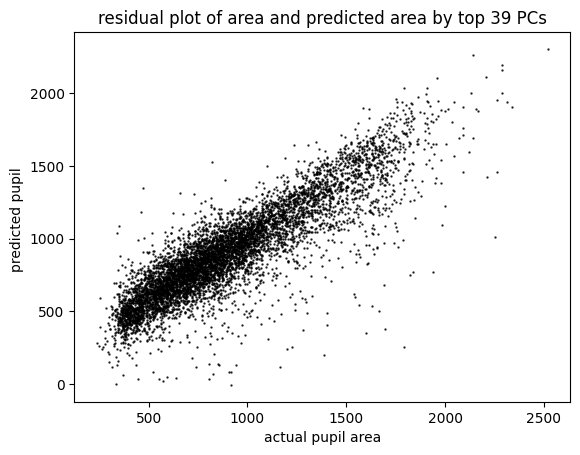

In [11]:
# find a smaller subset of neurons than 100
pcaSubset = PCA(n_components=.9, whiten=True).fit_transform(X.T)
# MSE
theta ,resi, _, _ = np.linalg.lstsq(pcaSubset, pArea)
# look at how far off it is
plt.scatter(pArea, pArea - pcaSubset @ theta, color='k', s=.5, alpha=.8)
plt.title('residual plot of area and predicted area by top 39 PCs')
plt.xlabel('actual pupil area')
plt.ylabel('predicted pupil ')

<ipython-input-12-ec44e2f89cba>:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta ,resi, _, _ = np.linalg.lstsq(pcaSubset, pArea)


Text(0, 0.5, 'predicted pupil ')

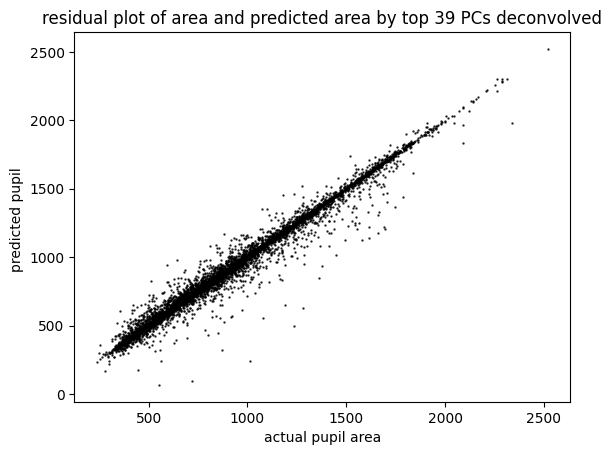

In [12]:
# repeat but with deconvolved data
pcaSubset = PCA(n_components=.9, whiten=True).fit_transform(smoothed.T)

theta ,resi, _, _ = np.linalg.lstsq(pcaSubset, pArea)
predicted = pArea - pcaSubset @ theta
plt.scatter(pArea, predicted, color='k', s=.5, alpha=.8)
plt.title('residual plot of area and predicted area by top 39 PCs deconvolved')
plt.xlabel('actual pupil area')
plt.ylabel('predicted pupil ')


# Can pupil size as a time series be used to predict pupil size?

With smoothed data. We want to see if we can forecast the next steps in the sequence given the previous points in the sequence.

- Our data is likely stationary because the trends in the data are a function of the stimulus and not the time at which the stimulus was recorded.
- We try smoothing the data to see if that helps to emphasize the larger points and general trend and not the low changes between pupil sizes
- We also try differencing the data to see if that helps to emphasize the changes. This sometimes can also turn a non-stationary time series process into a stationary process

**TODO**
* Metric for measuring prediction of forecast
* Metric for measuing correlcation between fitted and baseline for ARIMA

Text(0.5, 1.0, 'smoothed differences ')

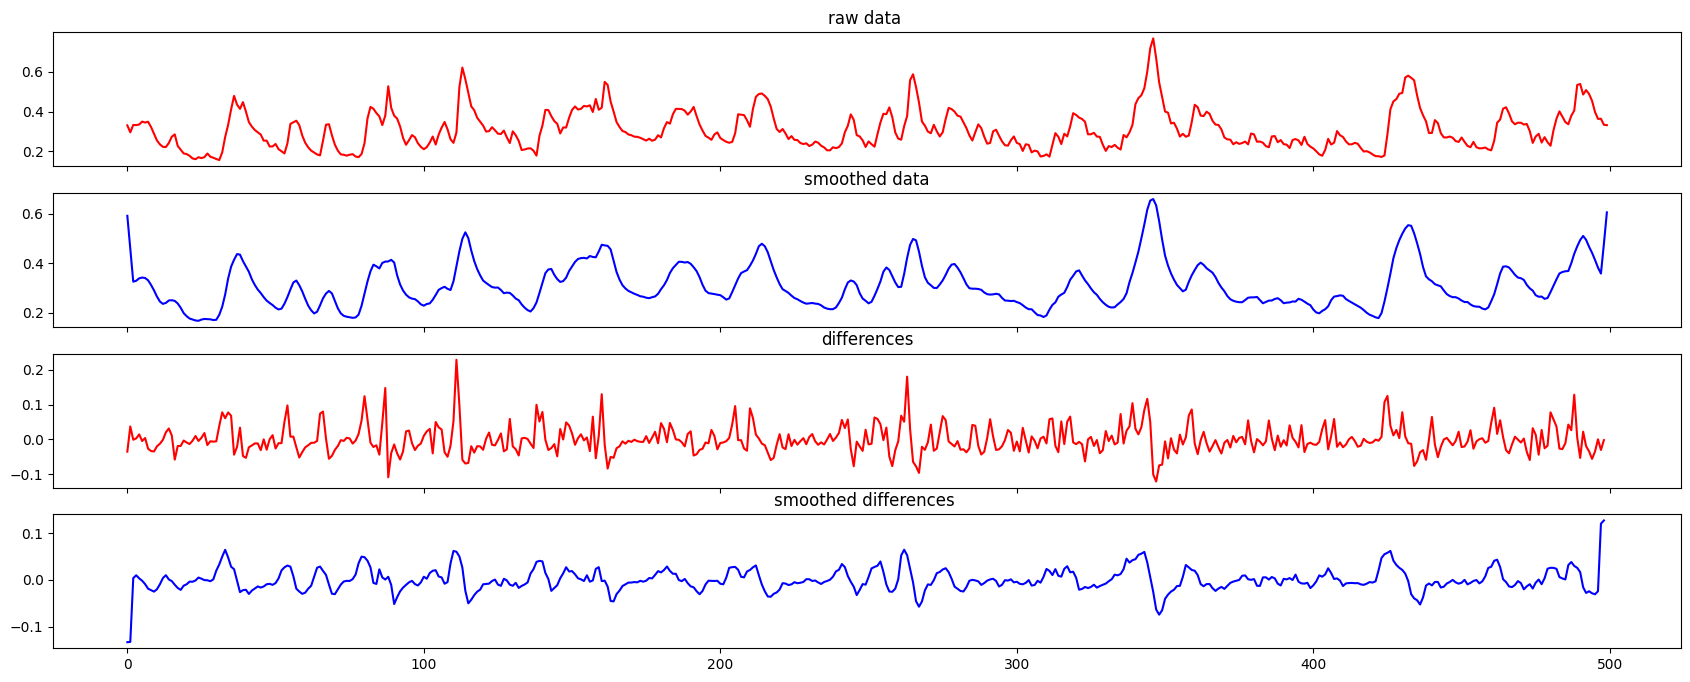

In [13]:
# @title Smooth out bumps in the plot by uniform 1d filter of Normalized data
nsubplots = 4
fig,ax = plt.subplots(nsubplots, 1, sharex=True, figsize =(21, 2*nsubplots))

#---- parameter changes -----
norm = (pArea/pArea.max())[:500]
shift = len(norm) // 100
filtered = uniform_filter1d(norm, shift, axis = 0, mode='constant', cval=1)
diff = np.diff(norm, axis = 0) #first difference
diff_smooth = np.diff(filtered, axis =0)
# tplots = [norm, filtered, differenced, differenced_smooth]
#---- plot changes -----
ax[0].plot(norm, color='red')
ax[0].set_title("raw data ")
ax[1].plot(filtered, color='blue')
ax[1].set_title("smoothed data")
ax[2].plot(diff, color='red')
ax[2].set_title("differences")
ax[3].plot(diff_smooth, color='blue')
ax[3].set_title("smoothed differences ")

Text(0.5, 1.0, 'PSD of smoothed 1^o difference')

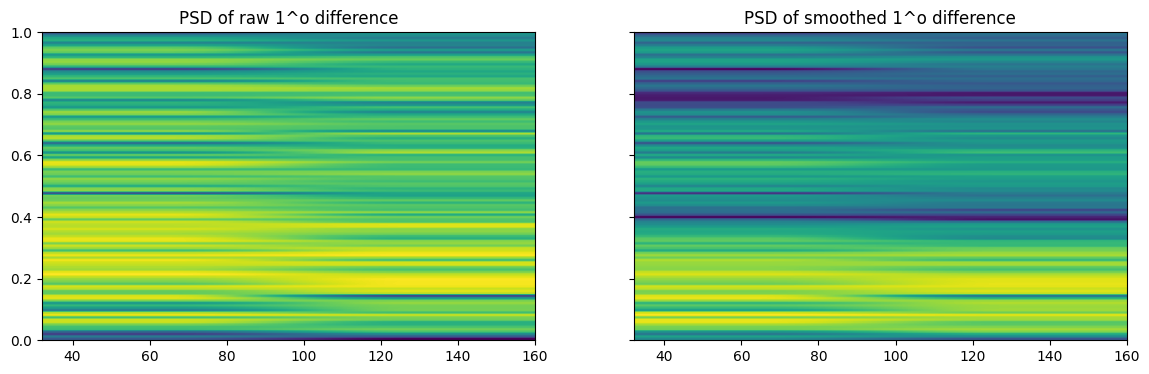

In [14]:
# @title for fun we can see what the smooth data looks like spectrographically
# @markdown this sort of shows us that big energy changes re concentrated in slower changes as opposed to faster ones.
nsubplots = 2
fig,ax = plt.subplots(1, nsubplots, sharey=True, figsize =(14, 2*nsubplots))
res = ax[0].specgram(x = diff.squeeze(), mode='psd')
ax[0].set_title('PSD of raw 1^o difference')
res = ax[1].specgram(x = diff_smooth.squeeze(), mode='psd')
ax[1].set_title('PSD of smoothed 1^o difference')

In [15]:
# @title create ARIMA from previous 5 time points.
# @markdown in an AR model we are simply using past values to form a regression predicted the next time point.But instead of using the values at a time point $t$ we are using the errors $\epsilon$
from statsmodels.tsa.arima.model import ARIMA
model_rough = ARIMA(norm, order=(5,1,0))
model_smooth = ARIMA(filtered, order=(5,1,0))
model_fit_rough = model_rough.fit()
model_fit_smooth = model_smooth.fit()
print(model_fit_rough.summary())
print(model_fit_smooth.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 947.274
Date:                Fri, 21 Jul 2023   AIC                          -1882.548
Time:                        13:18:58   BIC                          -1857.273
Sample:                             0   HQIC                         -1872.629
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4323      0.036     12.052      0.000       0.362       0.503
ar.L2         -0.1895      0.042     -4.491      0.000      -0.272      -0.107
ar.L3          0.0555      0.049      1.127      0.2

Text(0.5, 1.0, 'fitted smooth data vs smoothed data')

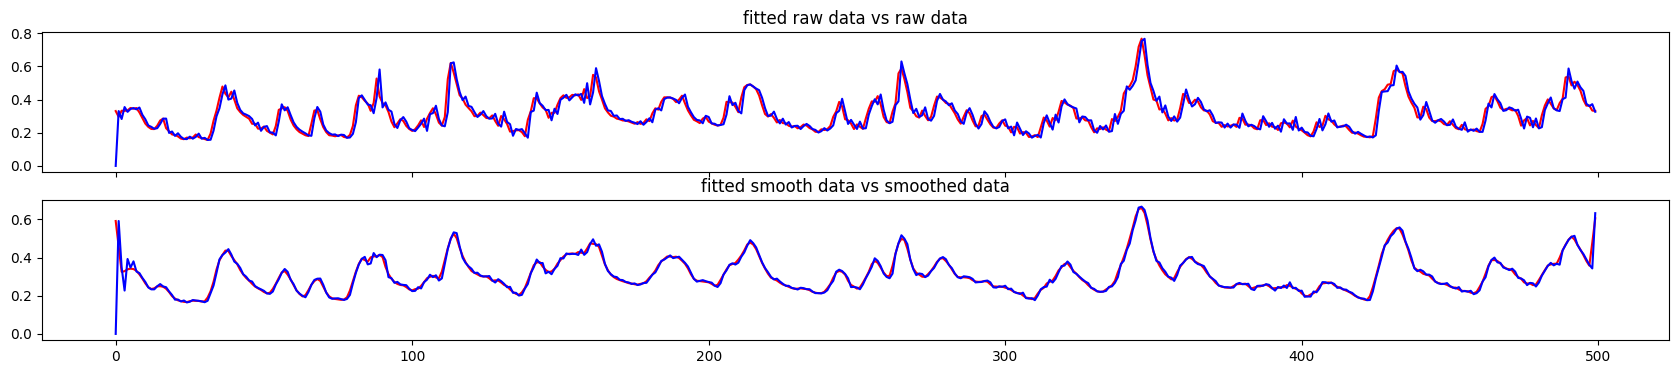

In [16]:
# @title look at fitted values; might be overfitting, but does better job on the smoothed data
nsubplots = 2
fig,ax = plt.subplots(nsubplots, 1, sharex=True, figsize =(21, 2*nsubplots))
#---- parameter changes -----
ax[0].plot(norm, color='red', label="raw")
ax[0].plot(model_fit_rough.fittedvalues, color='blue', label='fitted values')
ax[0].set_title("fitted raw data vs raw data")
ax[1].plot(filtered, color='red')
ax[1].plot(model_fit_smooth.fittedvalues, color='blue', label='fitted values')
ax[1].set_title("fitted smooth data vs smoothed data")

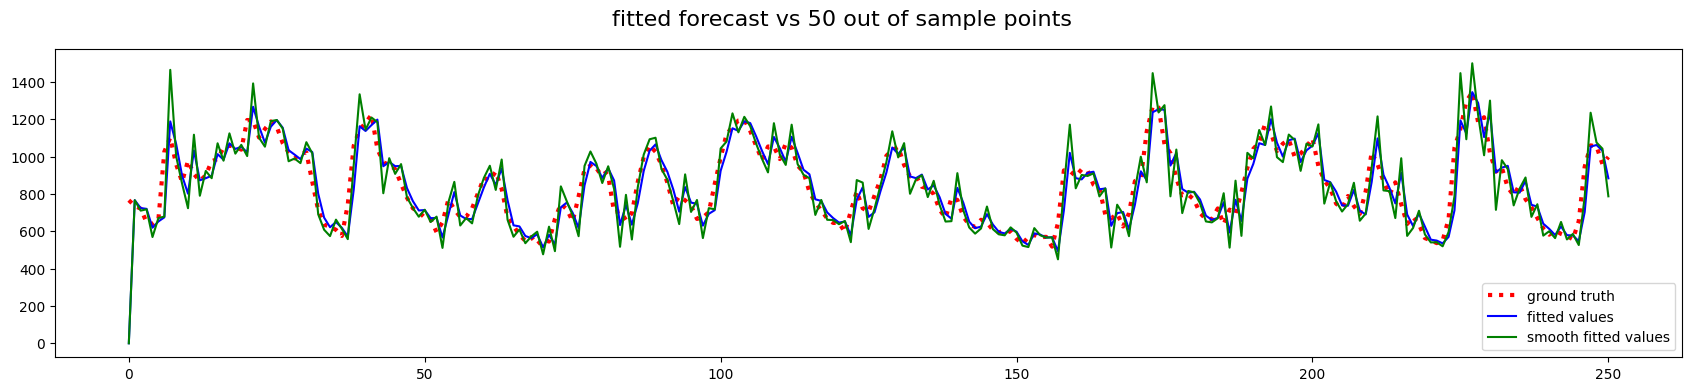

In [17]:
# @title Let's try out of sample data
# ------ hyperparameters
next_n_samples = 50 #@param {type:"raw"}
factor = 5
slide = factor * next_n_samples
# --- plotting things ------
nsubplots = 1
fig, ax = plt.subplots(nrows = nsubplots , ncols =1, sharex=True, figsize =(21, 4*nsubplots))
#---- out of sample of next 5 points in sequence
next_5_samples = pArea[500:500+slide+1]
rough_fcast = model_fit_rough.apply(next_5_samples)
smooth_fcast = model_fit_smooth.apply(next_5_samples)
ax.plot(next_5_samples, color='red', linewidth=3.0, linestyle='dotted', label="ground truth")
ax.plot(rough_fcast.fittedvalues, color='blue', linewidth = 1.5, linestyle='solid', label='fitted values')
ax.plot(smooth_fcast.fittedvalues, color='green',linewidth = 1.5,  linestyle='solid', label='smooth fitted values')
fig.suptitle(f"fitted forecast vs {next_n_samples} out of sample points", fontsize=16)
ax.legend()